In [39]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import torch

from sbi.utils import BoxUniform
from sbi.utils import MultipleIndependent
from sbi.analysis import pairplot


In [40]:
count_data = np.loadtxt("../../data/txtdata.csv")
n_count_data = len(count_data)

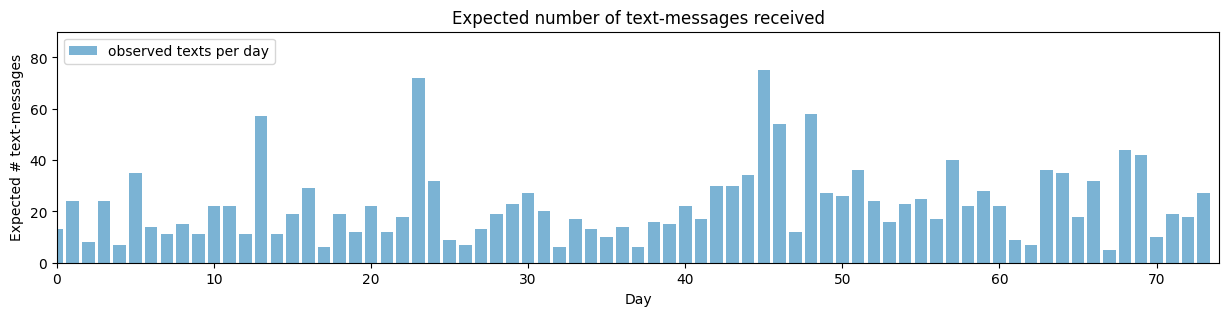

In [41]:
plt.figure(figsize=(15,3))
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 90)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left")
plt.show()

In [56]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float,axis=1)
    ret[:,n:] = ret[:,n:] - ret[:,:-n]
    return torch.as_tensor(ret[:,n - 1:] / n, dtype=torch.float32)

def simulator(params):
        #data = np.r_[stats.poisson.rvs(mu=params[0], size=int(params[2])), stats.poisson.rvs(mu=params[1], size=74 - int(params[2]))]
        #data=torch.cat(torch.poisson(params[:,0].unsqueeze(1).repeat(1,int(params[2]))),torch.poisson(params[:,1].unsqueeze(1).repeat(1,74-int(params[2]))),axis=1)
        data = torch.empty(0)
        for i in range(params.shape[0]):
            data1=torch.cat((torch.poisson(params[i,0].unsqueeze(0).repeat(1,int(params[i,2]))),torch.poisson(params[i,1].unsqueeze(0).repeat(1,74-int(params[i,2])))),axis=1)
            data=torch.cat((data,data1),axis=0)
        return data

# Prior definition
alpha=1./20.    
prior=MultipleIndependent(
    [
        torch.distributions.Exponential(rate=torch.ones(1)*0.05),
        torch.distributions.Exponential(rate=torch.ones(1)*0.05),
        torch.distributions.Uniform(low=torch.Tensor([0.0]),high=torch.Tensor([70.0]))
    ]
)

# number of simulations that we will be using
num_sims = 1000
num_rounds = 2

In [62]:
def view_result(posterior):
    posterior_samples = posterior.sample((10000,), x=x_o)
    # plot posterior samples
    fig, ax = pairplot(
        posterior_samples, figsize=(5, 5)
    )
    plt.show()

In [57]:
theta_o = torch.as_tensor([18, 26, 40],  dtype=torch.float32).unsqueeze(0)
x_o = moving_average(simulator(theta_o),n=5)

## NPE

### Fast ε-free Inference of Simulation Models with Bayesian Conditional Density Estimation

by Papamakarios & Murray (NeurIPS 2016) - does not work here because it requires that the prior be multivariate normal or box uniform

In [ ]:
# from sbi.inference import NPE_A

# inference = NPE_A(prior)
# proposal = prior
# for _ in range(num_rounds):
#     theta = proposal.sample((num_sims,))
#     x = simulator(theta)
#     _ = inference.append_simulations(theta, x, proposal=proposal).train()
#     posterior = inference.build_posterior().set_default_x(x_o)
#     proposal = posterior

### Automatic posterior transformation for likelihood-free inference

by Greenberg, Nonnenmacher & Macke (ICML 2019) 

In [58]:
from sbi.inference import NPE

inference = NPE(prior)
proposal = prior
for _ in range(num_rounds):
    theta = proposal.sample((num_sims,))
    x = moving_average(simulator(theta),n=5)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    proposal = posterior.set_default_x(x_o)

 Neural network successfully converged after 102 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 72 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

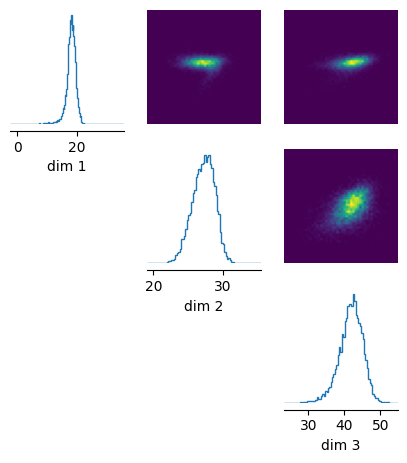

In [60]:
view_result(posterior)

### Flow Matching for Scalable Simulation-Based Inference
by Dax, Wildberger, Buchholz, Green, Macke, Schölkopf (NeurIPS 2023) 

In [64]:
from sbi.inference import FMPE

inference = FMPE(prior)
# FMPE does support multiple rounds of inference
theta = prior.sample((num_sims,))
x = moving_average(simulator(theta),n=5)
inference.append_simulations(theta, x).train()
posterior = inference.build_posterior().set_default_x(x_o)

 Neural network successfully converged after 186 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

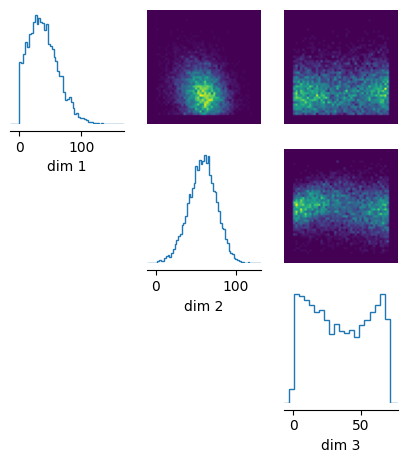

In [65]:
view_result(posterior)

## Likelihood estimation (NLE)¶

### Sequential neural likelihood: Fast likelihood-free inference with autoregressive flows
by Papamakarios, Sterratt & Murray (AISTATS 2019) 

In [66]:
from sbi.inference import NLE

inference = NLE(prior)
proposal = prior
for _ in range(num_rounds):
    theta = proposal.sample((num_sims,))
    x = moving_average(simulator(theta),n=5)
    _ = inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior(mcmc_method="slice_np_vectorized",
                                          mcmc_parameters={"num_chains": 20,
                                                           "thin": 5})
    proposal = posterior.set_default_x(x_o)

 Neural network successfully converged after 924 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/26000 [00:00<?, ?it/s]

 Neural network successfully converged after 235 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/71000 [00:00<?, ?it/s]

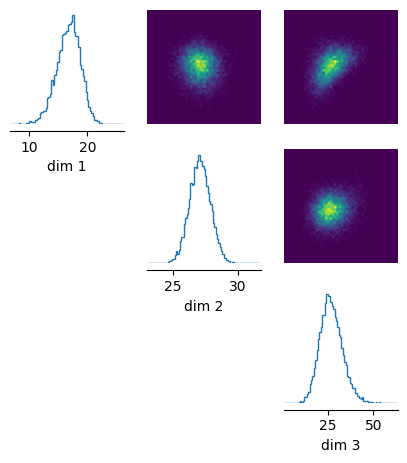

In [68]:
view_result(posterior)

### Variational methods for simulation-based inference
by Glöckler, Deistler, Macke (ICLR 2022) - takes a LONG time

In [ ]:
from sbi.inference import NLE

inference = NLE(prior)
proposal = prior
for _ in range(num_rounds):
    theta = proposal.sample((num_sims,))
    x = moving_average(simulator(theta),n=5)
    _ = inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior(sample_with="vi",
                                          vi_method="fKL").set_default_x(x_o)
    proposal = posterior.train()  # Train VI posterior on given x_o.

 Neural network successfully converged after 1105 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]

Quality Score: 2.516 	 Good: Smaller than 0.5  Bad: Larger than 1.0 	         NOTE: Less sensitive to mode collapse.
 Neural network successfully converged after 352 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
view_result(posterior)

## Likelihood-ratio estimation (NRE)¶

### Likelihood-free MCMC with Amortized Approximate Likelihood Ratios
by Hermans, Begy & Louppe (ICML 2020) 

In [70]:
from sbi.inference import NRE_A

inference = NRE_A(prior)
theta = prior.sample((num_sims,))
x = moving_average(simulator(theta),n=5)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior().set_default_x(x_o)

 Neural network successfully converged after 112 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

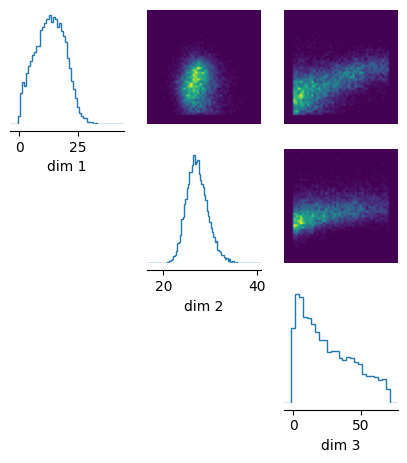

In [71]:
view_result(posterior)

### Contrastive Neural Ratio Estimation
Benjamin Kurt Miller, Christoph Weniger, Patrick Forré (NeurIPS 2022) 

In [ ]:
# The main feature of NRE-C is producing an exact ratio of densities at optimum,
# even when using multiple contrastive pairs (classes).

from sbi.inference import NRE_C

inference = NRE_C(prior)
proposal = prior
theta = proposal.sample((num_sims,))
x = simulator(theta)
_ = inference.append_simulations(theta, x).train(
    num_classes=5,  # sees `2 * num_classes - 1` marginally drawn contrastive pairs.
    gamma=1.0,  # controls the weight between terms in its loss function.
)
posterior = inference.build_posterior().set_default_x(x_o)